In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import re
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


Reference: https://www.kaggle.com/vishalsiram50/fine-tuning-bert-88-accuracy

In [2]:
!pip install transformers==2.8.0

     |████████████████████████████████| 563 kB 4.3 MB/s            
     |████████████████████████████████| 5.6 MB 56.4 MB/s            
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.10.3
    Uninstalling tokenizers-0.10.3:
      Successfully uninstalled tokenizers-0.10.3
  Attempting uninstall: transformers
    Found existing installation: transformers 4.12.5
    Uninstalling transformers-4.12.5:
      Successfully uninstalled transformers-4.12.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
allennlp 2.8.0 requires transformers<4.13,>=4.1, but you have transformers 2.8.0 which is incompatible.


In [3]:
train = pd.read_csv('../input/nlp-getting-started/train.csv')
test = pd.read_csv('../input/nlp-getting-started/test.csv')
submission = pd.read_csv('../input/nlp-getting-started/sample_submission.csv')

Data cleaning

In [4]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
import nltk
# Uncomment to download "stopwords"
nltk.download("stopwords")
from nltk.corpus import stopwords

def text_preprocessing(s):
    s = s.lower()
    # Change 't to 'not'
    s = re.sub(r"\'t", " not", s)
    # Remove @name
    s = re.sub(r'(@.*?)[\s]', ' ', s)
    # Isolate and remove punctuations except '?'
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove stopwords except 'not' and 'can'
    s = " ".join([word for word in s.split()
                  if word not in stopwords.words('english')
                  or word in ['not', 'can']])
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()
    
    return s

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


BERT Tokenizer

In [7]:
# https://www.kaggle.com/vishalsiram50/fine-tuning-bert-88-accuracy
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Data preprocessing
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,             # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [8]:
# Concatenate train data and test data
all_tweets = np.concatenate([train.text.values, test.text.values])

# Encode our concatenated data
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_tweets]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

Max length:  84


In [9]:
from sklearn.model_selection import train_test_split

X = train.text.values
y = train.target.values

X_train, X_val, y_train, y_val =\
    train_test_split(X, y, test_size=0.1, random_state=42)

In [10]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla P100-PCIE-16GB


In [11]:
# Specify `MAX_LEN`
MAX_LEN = max_len

# Print sentence 0 and its encoded token ids
X = train.text.values
token_ids = list(preprocessing_for_bert([X[0]])[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)
print('Done!')

Original:  Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Token IDs:  [101, 15616, 3114, 8372, 2089, 16455, 9641, 2149, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tokenizing data...
Done!


Create PyTorch DataLoader

In [12]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

 Train Model

In [13]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 42 µs, sys: 0 ns, total: 42 µs
Wall time: 45.3 µs


Optimizer & Learning Rate Scheduler

In [14]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=10):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [15]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

In [16]:
def train(model, train_dataloader, val_dataloader=None, epochs=10, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")

In [17]:
def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [18]:
import warnings
warnings.filterwarnings("ignore")
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=5)
train(bert_classifier, train_dataloader, val_dataloader, epochs=5, evaluation=True)

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.630686   |     -      |     -     |   6.85   
   1    |   40    |   0.498968   |     -      |     -     |   5.70   
   1    |   60    |   0.469458   |     -      |     -     |   5.67   
   1    |   80    |   0.447198   |     -      |     -     |   5.71   
   1    |   100   |   0.382192   |     -      |     -     |   5.68   
   1    |   120   |   0.418440   |     -      |     -     |   5.71   
   1    |   140   |   0.403070   |     -      |     -     |   5.73   
   1    |   160   |   0.467568   |     -      |     -     |   5.72   
   1    |   180   |   0.418097   |     -      |     -     |   5.69   
   1    |   200   |   0.406872   |     -      |     -     |   5.72   
   1    |   214   |   0.409767   |     -      |     -     |   3.78   
----------------------------------------------------------------------

In [19]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [20]:
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

[[0.96972656 0.03027341]
 [0.98706543 0.01293461]
 [0.66460425 0.33539578]
 ...
 [0.00705937 0.99294066]
 [0.99321413 0.00678591]
 [0.9743435  0.0256566 ]]
AUC: 0.8585
Accuracy: 79.92%


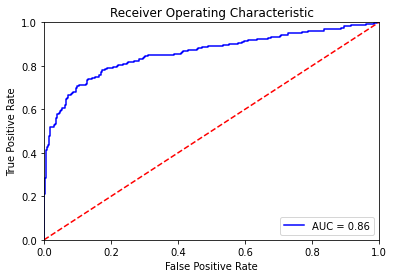

In [21]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, val_dataloader)
print(probs)
# Evaluate the Bert classifier
evaluate_roc(probs, y_val)

In [22]:
# Concatenate the train set and the validation set
full_train_data = torch.utils.data.ConcatDataset([train_data, val_data])
full_train_sampler = RandomSampler(full_train_data)
full_train_dataloader = DataLoader(full_train_data, sampler=full_train_sampler, batch_size=32)

# Train the Bert Classifier on the entire training data
set_seed(42)
bert_classifier, optimizer, scheduler = initialize_model(epochs=4)
train(bert_classifier, full_train_dataloader, epochs=4)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.568642   |     -      |     -     |   6.00   
   1    |   40    |   0.489699   |     -      |     -     |   5.78   
   1    |   60    |   0.468779   |     -      |     -     |   5.68   
   1    |   80    |   0.443554   |     -      |     -     |   5.72   
   1    |   100   |   0.500796   |     -      |     -     |   5.68   
   1    |   120   |   0.453577   |     -      |     -     |   5.73   
   1    |   140   |   0.447424   |     -      |     -     |   5.73   
   1    |   160   |   0.451307   |     -      |     -     |   5.74   
   1    |   180   |   0.393817   |     -      |     -     |   5.71   
   1    |   200   |   0.426303   |     -      |     -     |   5.68   
   1    |   220   |   0.407856   |     -      |     -     |   5.71   
   1    |   237   |   0.461839   |     -      |     -     |   4.83   


Predictions on Test Set

In [23]:
# Run `preprocessing_for_bert` on the test set
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bert(test.text)

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)
print('Done!')

Tokenizing data...
Done!


In [24]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)
print(probs)

# Get predictions from the probabilities
threshold = 0.9
preds = np.where(probs[:, 1] > threshold, 1, 0)

# Number of tweets predicted non-negative
print("Number of tweets predicted non-negative: ", preds.sum())

[[0.0193708  0.9806292 ]
 [0.01356297 0.986437  ]
 [0.01300307 0.9869969 ]
 ...
 [0.01260686 0.98739314]
 [0.01421044 0.9857896 ]
 [0.01470511 0.98529494]]
Number of tweets predicted non-negative:  1156


In [25]:
output = test[preds==1]
list(output.sample(20).text)

["'Islamic State' group claims Saudi mosque suicide blast: The jihadist group claims it sent a suicide bomber to\x89Û_ http://t.co/H2CTpG4oyZ #dw",
 "Black African refugees in 'Israel' cannot attend Kenye West concert due to curfew for black refugees.. http://t.co/S0usjQYIJe",
 '@johncusack text: We Dropped The A-Bomb (1946)https://t.co/boJCX32qcZ \x89Û_',
 '#?? #?? #??? #??? MH370: Aircraft debris found on La Reunion is from missing Malaysia Airlines ...  http://t.co/ykLruIMIsD',
 'Here we are 70 years after the nuclear obliteration of Hiroshima and Nagasaki and I\x89Ûªm wondering i\x89Û_ http://t.co/fvkekft4Rs',
 'Burning Buildings.\n\nKeep The Flames Lit. ??????',
 'RT RTphotographyUK: New #photo Oak in a snowstorm http://t.co/gWOKZELq5Q taken in #winter on the #SouthDowns #Hampshire #photography #art\x89Û_',
 'Flash floods landslides possible as Hanna draws in more monsoon rains - Pagasa http://t.co/TzWmsEQPHW | via News5 #iBalita',
 "AFP: #PKK said it carried out suicide bombing a

In [26]:
preds

array([1, 1, 1, ..., 1, 1, 1])

In [27]:
submission['target'] = preds
submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [28]:
submission.to_csv('submission.csv', index=False)